# Project: Using statistical Null hypothesis testing to show that the distribution of proteins that works together has significantly difference with proteins that not works together in Gene Ontology Namespaces.

## First distribution is proteins that works together
## Second distribution is proteins that don't  works together
## Null hypothesis is: they are not different.
## H0: p1=p2  versus HA: p1≠p2

## Gitlab links : [click here](https://gitlab.com/Ilia_Abolhasani/analysis-of-biological-networks-finial-project)

### Select our statistical hypothesis test  base on this roadmap:

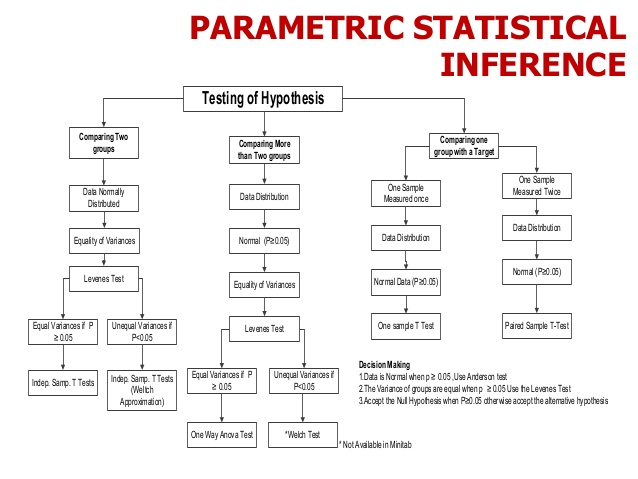

# Imports

In [82]:
from collections import namedtuple
from IPython.display import clear_output  # for clear cell display
import sys
import time
import numpy as np
import pandas as pd
import networkx as nx
# Bio
import Bio
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist  # for blosom matrix score for alignment
# community
from networkx.algorithms import community
import community as community_louvain
import scipy.stats as stat
# matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# p-value functions :

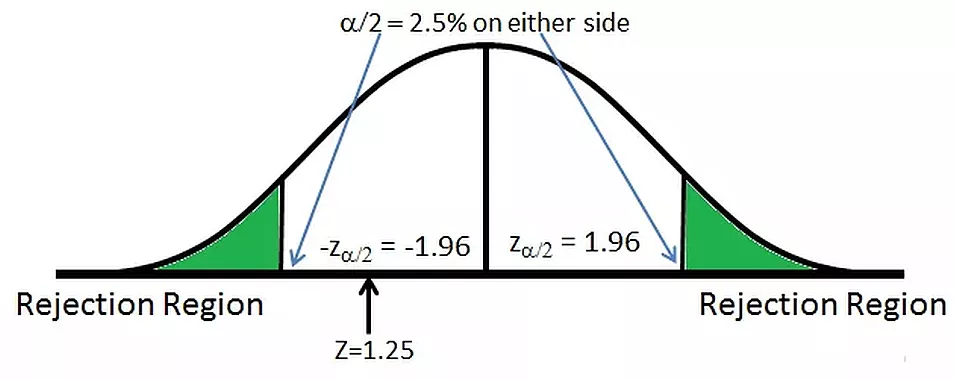

# Notice :

## If the number of data is large, we can use parametric methods based on the Central limit theorem.
## If the number of data is not large enough, we should use Kolmogorov–Smirnov test to to decide, if Kolmogorov–Smirnov test is significance (p <0.5), then we should use non parametric methods, otherwise we should use parametric methods.

### We use parametric methods because we have a lot of data and these methods are more accurate

In [83]:
def fisher(dist1,dist2):
    [oddsratio, pvalue] = stat.fisher_exact([[sum(dist1), len(dist1) - sum(dist1)], [sum(dist2), len(dist2) - sum(dist2)]])
    print(f'P-value for fisher exact test is : {pvalue}')

In [84]:
# Welch–Satterthwaite equation
# t test for samples with not same size 
TtestResults = namedtuple("Ttest", "T p")

def t_welch(x, y, tails=2):
    """
    Welch's t-test for two unequal-size samples, not assuming equal variances
    """
    assert tails in (1,2), "invalid: tails must be 1 or 2, found %s"%str(tails)
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = x.size, y.size
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    df = ((vx/nx + vy/ny)**2 / # Welch-Satterthwaite equation
            ((vx/nx)**2 / (nx - 1) + (vy/ny)**2 / (ny - 1)))
    t_obs = (x.mean() - y.mean()) / np.sqrt(vx/nx + vy/ny)
    p_value = tails * st.t.sf(abs(t_obs), df)
    return TtestResults(t_obs, p_value)


In [85]:
def show_pvalue(dist1,dist2):
    statistic , pvalue = stat.ttest_ind(dist1, dist2)
    print(f'P-value for t test is : {pvalue}')
    statistic, pvalue = stat.f_oneway(dist1,dist2)
    print(f'P-value for the one-way ANOVA test is : {pvalue}')

## Show plots

In [86]:
def show_dist(dist1,dist2, title="Distributions"):
    sns.distplot(dist1, color="maroon")
    sns.distplot(dist2, color="Teal")    
    #plt.xlabel("value", labelpad=14)
    plt.ylabel("probability of occurence", labelpad=14)
    plt.title(title, y=1.015, fontsize=20);

In [87]:
def show_dist_bernoulli(dist1,dist2, title="Distributions"):    
    data = [[(len(dist1) - sum(dist1)) /len(dist1),sum(dist1)/len(dist1)],
    [(len(dist2) - sum(dist2))/len(dist2),sum(dist2)/len(dist2)]]
    X = np.arange(2)
    fig = plt.figure()    
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X - 0.125, data[0], color = 'b', width = 0.25)
    ax.bar(X + 0.125, data[1], color = 'g', width = 0.25)
    #plt.xlabel("value", labelpad=14)
    plt.ylabel("probability of occurence", labelpad=14)
    plt.title(title, y=1.015, fontsize=20);    

# load workers :

In [88]:
def load_workers(address):
    df = pd.read_csv(address)
    df = df.drop(['Unnamed: 0'], axis=1)
    coworks = df.loc[df['works'] > 0]
    ncoworks = df.loc[df['works'] == 0]
    coworks.reset_index(inplace = True) 
    ncoworks.reset_index(inplace = True) 
    print(df.shape)
    print(f'coworks size : {coworks.shape}')
    print(f'not coworks size : {ncoworks.shape}\n')    
    del(df)
    return [coworks, ncoworks]

## function for get protein sequence

In [89]:
def get_protein_seq(address):
    df = pd.read_pickle(address)
    df = df[['accessions','sequences']]
    proteins = np.array(df.iloc[:,0])
    seqs = np.array(df.iloc[:,1])
    proteins2seq = dict()
    for i in range(0,df.shape[0]):
        proteins2seq[proteins[i]] = seqs[i]
    return proteins2seq

# load PPI network

In [90]:
ppi = pd.read_csv('./data/PPI.csv')
G = nx.from_pandas_edgelist(ppi,source='protein1',target='protein2')
print(nx.info(G))
print(f'number of connected components : {nx.number_connected_components(G)}')

Name: 
Type: Graph
Number of nodes: 9167
Number of edges: 63822
Average degree:  13.9243
number of connected components : 72


#  Main function for calc distribution :

In [91]:
def get_dist(df,method,protein2seq,partition):
        dist = np.zeros(df.shape[0],dtype=int)   
        p1 = np.array(df.iloc[:,1])
        p2 = np.array(df.iloc[:,2])
        # for method 4 and 5
        matrix = matlist.blosum62
        oppening_gap = -1
        extend_gap = -0.2
        # loop
        for i in range(0,df.shape[0]):                    
            if(method == 1):  # Shortest path length
                try:
                    dist[i] = nx.shortest_path_length(G,source=p1[i],target=p2[i])                                    
                except Exception as e:            
                    dist[i] = -1
                    
            elif(method == 2):  # Neighborhood
                dist[i] = int(G.has_edge(p1[i],p2[i]))
                
            elif(method == 3):  # Common neighbors
                dist[i] = len(set(G.neighbors(p1[i])).intersection(set(G.neighbors(p2[i]))))
                
            elif(method == 4):  # Protein string similarity
                s1 = protein2seq[p1[i]]                
                s2 = protein2seq[p2[i]]                                
                dist[i] = pairwise2.align.globalxx(s1,s2)[0].score 
                #dist[i] = pairwise2.align.globaldd(s1,s2,matrix,-1, -1, oppening_gap,extend_gap)[0].score                                        
                
            elif(method == 5):  # Protein string similarity in common neighbor
                if(len(set(G.neighbors(p1[i])).intersection(set(G.neighbors(p2[i])))) > 0):            
                    s1 = protein2seq[p1[i]]                
                    s2 = protein2seq[p2[i]]                
                    dist[i] = pairwise2.align.globalxx(s1,s2)[0].score                                        
                    #dist[i] = pairwise2.align.globaldd(s1,s2,matrix,-1, -1, oppening_gap,extend_gap)[0].score                                        
                else:
                    dist[i] = 0
                    
            elif(method == 6):  # Same communities
                dist[i] = partition[p1[i]] == partition[p2[i]]
            elif(method == 7): # Same communities neighbors
                if(partition[p1[i]] == partition[p2[i]]):
                    dist[i] = len(list(G.neighbors(p1[i])))+len(list(G.neighbors(p2[i])))
                else:
                    dist[i] = 0
            elif(method == 8):  # Proposed method                
                try:
                    y = np.bincount([partition[n] for n  in G.neighbors(p1[i])])
                    a =  1 - sum(y**2) / (sum(y)**2)
                    y = np.bincount([partition[n] for n  in G.neighbors(p2[i])])
                    b =  1 - sum(y**2) / (sum(y)**2)                    
                    dist[i] = a+b
                except :
                    print('error')
                    dist[i]= 0
                        
            if(i%1000==0 and i >0):
                print(i)
                clear_output(wait=True)
        return dist
                
def get_distribution(coworks,ncoworks,method=1,protein2seq=None,partition=None):    
    start_time = time.time()    
    coworks_dist = get_dist(coworks, method, protein2seq, partition)
    ncoworks_dist =  get_dist(ncoworks, method, protein2seq, partition)
    print("--- %s seconds ---" % round(time.time() - start_time,2))                
    return [coworks_dist,ncoworks_dist]

# Exectue

In [92]:
print("Biological Process")
[coworks_bp, ncoworks_bp] = load_workers('./data/workers_bp.csv')

Biological Process
(7347861, 3)
coworks size : (6053166, 4)
not coworks size : (1294695, 4)



In [93]:
print("Cellular Components")
[coworks_cc, ncoworks_cc] = load_workers('./data/workers_cc.csv')

Cellular Components
(9765990, 3)
coworks size : (8775199, 4)
not coworks size : (990791, 4)



In [94]:
print("Molecular Function")
[coworks_mf, ncoworks_mf] = load_workers('./data/workers_mf.csv')

Molecular Function
(4969128, 3)
coworks size : (2841537, 4)
not coworks size : (2127591, 4)



## Shortest path length

In [61]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,1)
np.save('./data/shortest path length-coworks_dist-bp.npy', coworks_dist)
np.save('./data/shortest path length-ncoworks_dist-bp.npy', ncoworks_dist)

--- 804.93 seconds ---


P-value for t test is : 7.047234666641594e-14
P-value for the one-way ANOVA test is : 7.047234666820855e-14


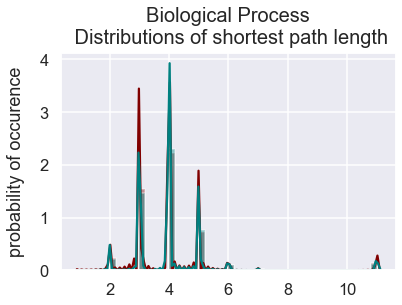

In [590]:
# preprocess data, replace -1 to max distance + 1 When there is no path between two nodes
coworks_dist = np.load('./data/shortest path length-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/shortest path length-ncoworks_dist-bp.npy')
coworks_dist[coworks_dist==-1] = max(coworks_dist) + 1
ncoworks_dist[ncoworks_dist==-1] = max(ncoworks_dist) + 1
show_dist(coworks_dist,ncoworks_dist,"Biological Process\n Distributions of shortest path length")
show_pvalue(coworks_dist,ncoworks_dist)

In [62]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,1)
np.save('./data/shortest path length-coworks_dist-cc.npy', coworks_dist)
np.save('./data/shortest path length-ncoworks_dist-cc.npy', ncoworks_dist)

--- 1045.06 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0
z test -0.03501050751714102


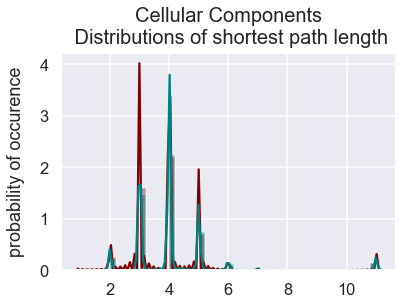

In [549]:
# preprocess data, replace -1 to max distance + 1 When there is no path between two nodes
coworks_dist = np.load('./data/shortest path length-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/shortest path length-ncoworks_dist-cc.npy')
coworks_dist[coworks_dist==-1] = max(coworks_dist) + 1
ncoworks_dist[ncoworks_dist==-1] = max(ncoworks_dist) + 1
show_dist(coworks_dist,ncoworks_dist,"Cellular Components\n Distributions of shortest path length")
show_pvalue(coworks_dist,ncoworks_dist)

In [63]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,1)
np.save('./data/shortest path length-coworks_dist-mf.npy', coworks_dist)
np.save('./data/shortest path length-ncoworks_dist-bp.npy', ncoworks_dist)

--- 585.81 seconds ---


P-value for t test is : 0.00010352625305932282
P-value for the one-way ANOVA test is : 0.00010352625301357316


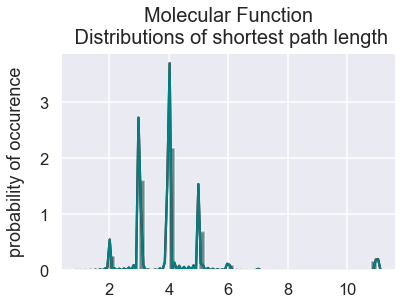

In [415]:
# preprocess data, replace -1 to max distance + 1 When there is no path between two nodes
coworks_dist = np.load('./data/shortest path length-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/shortest path length-ncoworks_dist-mf.npy')
coworks_dist[coworks_dist==-1] = max(coworks_dist) + 1
ncoworks_dist[ncoworks_dist==-1] = max(ncoworks_dist) + 1
show_dist(coworks_dist,ncoworks_dist,"Molecular Function\n Distributions of shortest path length")
show_pvalue(coworks_dist,ncoworks_dist)

## Neighborhood

In [64]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,2)
np.save('./data/neighborhood-coworks_dist-bp.npy', coworks_dist)
np.save('./data/neighborhood-ncoworks_dist-bp.npy', ncoworks_dist)

--- 16.54 seconds ---


P-value for fisher exact test is : 5.234312733671e-06


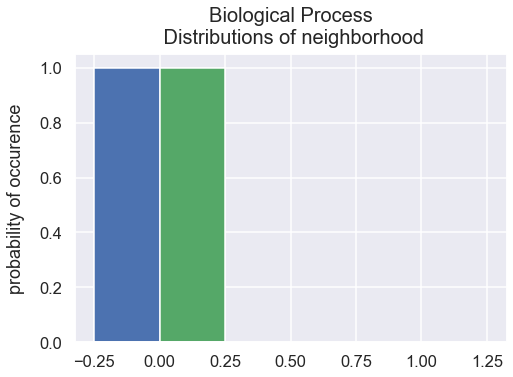

In [462]:
coworks_dist = np.load('./data/neighborhood-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/neighborhood-ncoworks_dist-bp.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Biological Process\n Distributions of neighborhood")
fisher(coworks_dist,ncoworks_dist)

In [65]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,2)
np.save('./data/neighborhood-coworks_dist-cc.npy', coworks_dist)
np.save('./data/neighborhood-ncoworks_dist-cc.npy', ncoworks_dist)

--- 21.64 seconds ---


P-value for fisher exact test is : 3.0293562511090755e-13


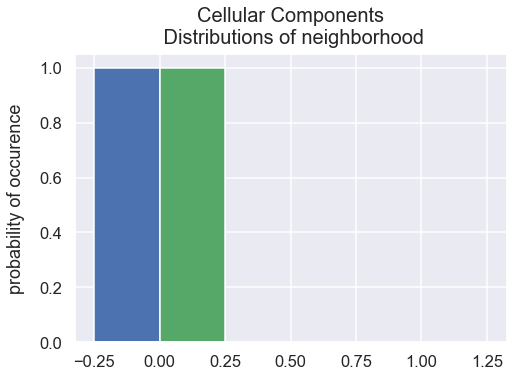

In [463]:
coworks_dist = np.load('./data/neighborhood-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/neighborhood-ncoworks_dist-cc.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Cellular Components\n Distributions of neighborhood")
fisher(coworks_dist,ncoworks_dist)

In [66]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,2)
np.save('./data/neighborhood-coworks_dist-mf.npy', coworks_dist)
np.save('./data/neighborhood-ncoworks_dist-mf.npy', ncoworks_dist)

--- 13.19 seconds ---


P-value for fisher exact test is : 5.234556907935931e-17


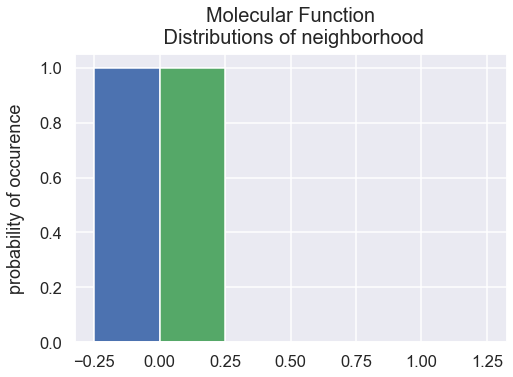

In [464]:
coworks_dist = np.load('./data/neighborhood-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/neighborhood-ncoworks_dist-mf.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Molecular Function\n Distributions of neighborhood")
fisher(coworks_dist,ncoworks_dist)

## Common neighbors

In [67]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,3)
np.save('./data/common neighbors-coworks_dist-bp.npy', coworks_dist)
np.save('./data/common neighbors-ncoworks_dist-bp.npy', ncoworks_dist)

--- 43.91 seconds ---


P-value for t test is : 8.337911767505256e-60
P-value for the one-way ANOVA test is : 8.3379117651661e-60


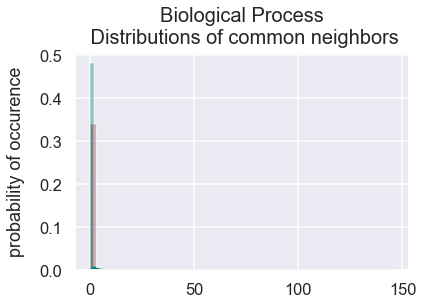

In [445]:
coworks_dist = np.load('./data/common neighbors-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/common neighbors-ncoworks_dist-bp.npy')
show_dist(coworks_dist,ncoworks_dist,"Biological Process\n Distributions of common neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [68]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,3)
np.save('./data/common neighbors-coworks_dist-cc.npy', coworks_dist)
np.save('./data/common neighbors-ncoworks_dist-cc.npy', ncoworks_dist)

--- 60.26 seconds ---


P-value for t test is : 3.267342870482894e-09
P-value for the one-way ANOVA test is : 3.2673428696885208e-09


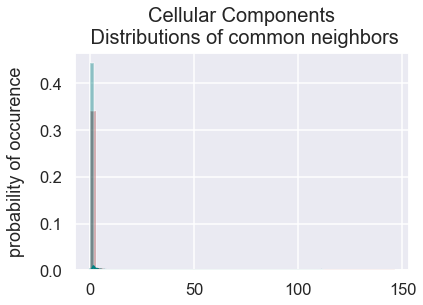

In [416]:
coworks_dist = np.load('./data/common neighbors-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/common neighbors-ncoworks_dist-cc.npy')
show_dist(coworks_dist,ncoworks_dist,"Cellular Components\n Distributions of common neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [70]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,3)
np.save('./data/common neighbors-coworks_dist-mf.npy', coworks_dist)
np.save('./data/common neighbors-ncoworks_dist-mf.npy', ncoworks_dist)

--- 29.15 seconds ---


P-value for t test is : 8.962837424422997e-42
P-value for the one-way ANOVA test is : 8.962837422899985e-42


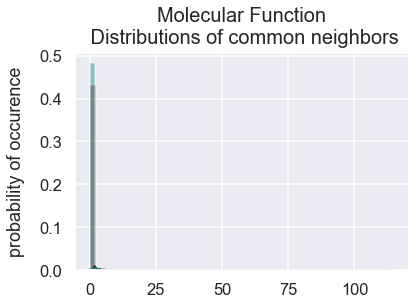

In [417]:
coworks_dist = np.load('./data/common neighbors-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/common neighbors-ncoworks_dist-mf.npy')
show_dist(coworks_dist,ncoworks_dist,"Molecular Function\n Distributions of common neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

## Protein string similarity

### The data was sampled for 100000 because I don't have access to a strong processing system.( only for alignment parts)

In [168]:
samplesize = 100000
scoworks_bp = coworks_bp.iloc[:samplesize,:]
sncoworks_bp = ncoworks_bp.iloc[:samplesize,:]
scoworks_cc = coworks_cc.iloc[:samplesize,:]
sncoworks_cc = ncoworks_cc.iloc[:samplesize,:]
scoworks_mf = coworks_mf.iloc[:samplesize,:]
sncoworks_mf = ncoworks_mf.iloc[:samplesize,:]

In [169]:
# Biological Process 
protein2seq = get_protein_seq('./data/train-bp.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_bp,sncoworks_bp,4,protein2seq)
np.save('./data/protein string similarity-coworks_dist-bp.npy', coworks_dist)
np.save('./data/protein string similarity-ncoworks_dist-bp.npy', ncoworks_dist)

--- 6513.46 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


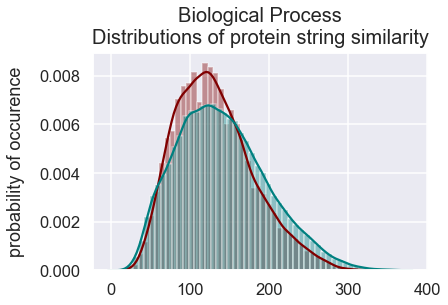

In [546]:
coworks_dist = np.load('./data/protein string similarity-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/protein string similarity-ncoworks_dist-bp.npy')
show_dist(coworks_dist,ncoworks_dist,"Biological Process\nDistributions of protein string similarity")
show_pvalue(coworks_dist,ncoworks_dist)

In [171]:
# Cellular Components
protein2seq = get_protein_seq('./data/train-cc.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_cc,sncoworks_cc,4,protein2seq)
np.save('./data/protein string similarity-coworks_dist-cc.npy', coworks_dist)
np.save('./data/protein string similarity-ncoworks_dist-cc.npy', ncoworks_dist)

--- 6095.35 seconds ---


P-value for t test is : 7.242072087214242e-127
P-value for the one-way ANOVA test is : 7.242072087723187e-127


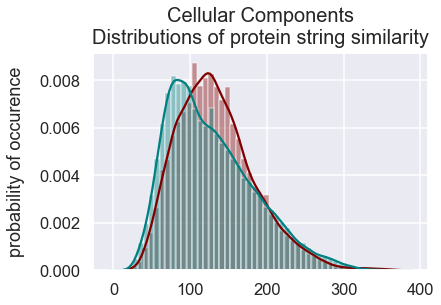

In [548]:
coworks_dist = np.load('./data/protein string similarity-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/protein string similarity-ncoworks_dist-cc.npy')
show_dist(coworks_dist,ncoworks_dist,"Cellular Components\nDistributions of protein string similarity")
show_pvalue(coworks_dist,ncoworks_dist)

In [172]:
# Molecular Function
protein2seq = get_protein_seq('./data/train-mf.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_mf,sncoworks_mf,4,protein2seq)
np.save('./data/protein string similarity-coworks_dist-mf.npy', coworks_dist)
np.save('./data/protein string similarity-ncoworks_dist-mf.npy', ncoworks_dist)

--- 8807.65 seconds ---


P-value for t test is : 1.4804205650452357e-30
P-value for the one-way ANOVA test is : 1.4804205651556667e-30


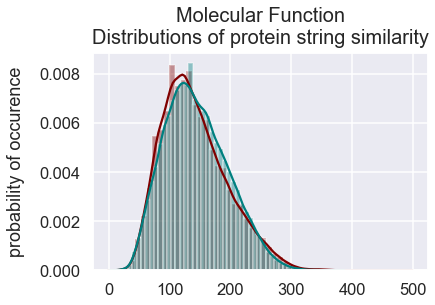

In [544]:
coworks_dist = np.load('./data/protein string similarity-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/protein string similarity-ncoworks_dist-mf.npy')
show_dist(coworks_dist,ncoworks_dist,"Molecular Function\nDistributions of protein string similarity")
show_pvalue(coworks_dist,ncoworks_dist)

## Protein string similarity in common neighbor

In [173]:
# Biological Process 
protein2seq = get_protein_seq('./data/train-bp.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_bp,sncoworks_bp,5,protein2seq)
np.save('./data/similarity in common neighbor-coworks_dist-bp.npy', coworks_dist)
np.save('./data/similarity in common neighbor-ncoworks_dist-bp.npy', ncoworks_dist)

--- 284.31 seconds ---


P-value for t test is : 4.186560717814746e-34
P-value for the one-way ANOVA test is : 4.186560718115576e-34


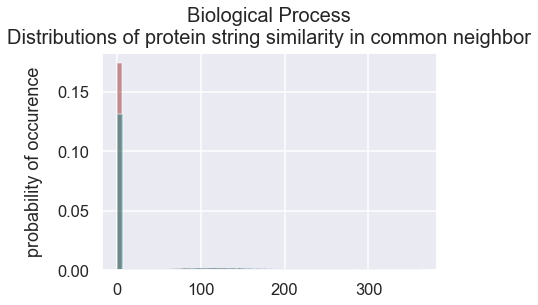

In [421]:
coworks_dist = np.load('./data/similarity in common neighbor-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/similarity in common neighbor-ncoworks_dist-bp.npy')
show_dist(coworks_dist,ncoworks_dist,"Biological Process\nDistributions of protein string similarity in common neighbor")
show_pvalue(coworks_dist,ncoworks_dist)

In [174]:
# Cellular Components
protein2seq = get_protein_seq('./data/train-cc.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_cc,sncoworks_cc,5,protein2seq)
np.save('./data/similarity in common neighbor-coworks_dist-cc.npy', coworks_dist)
np.save('./data/similarity in common neighbor-ncoworks_dist-cc.npy', ncoworks_dist)

--- 302.73 seconds ---


P-value for t test is : 0.15793592778596996
P-value for the one-way ANOVA test is : 0.157935927793104


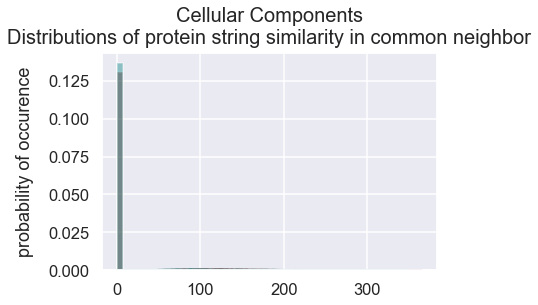

In [422]:
coworks_dist = np.load('./data/similarity in common neighbor-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/similarity in common neighbor-ncoworks_dist-cc.npy')
show_dist(coworks_dist,ncoworks_dist,"Cellular Components\nDistributions of protein string similarity in common neighbor")
show_pvalue(coworks_dist,ncoworks_dist)

In [175]:
# Molecular Function
protein2seq = get_protein_seq('./data/train-mf.pkl')
[coworks_dist,ncoworks_dist] = get_distribution(scoworks_mf,sncoworks_mf,5,protein2seq)
np.save('./data/similarity in common neighbor-coworks_dist-mf.npy', coworks_dist)
np.save('./data/similarity in common neighbor-ncoworks_dist-mf.npy', ncoworks_dist)

--- 336.07 seconds ---


P-value for t test is : 2.805267020689809e-44
P-value for the one-way ANOVA test is : 2.8052670208697006e-44


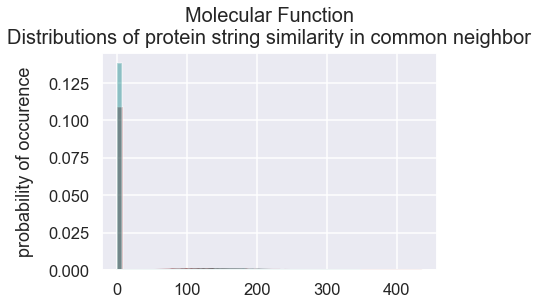

In [423]:
coworks_dist = np.load('./data/similarity in common neighbor-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/similarity in common neighbor-ncoworks_dist-mf.npy')
show_dist(coworks_dist,ncoworks_dist,"Molecular Function\nDistributions of protein string similarity in common neighbor")
show_pvalue(coworks_dist,ncoworks_dist)

## Same communities

###  two community method

In [96]:
# Louvain heuristices
partition1 = community_louvain.best_partition(G)

In [97]:
# Label propagation community detection algorithms.
cmn = community.label_propagation_communities(G)
partition2 = dict()
countr = 0;
for m in cmn:
    for n in m:
        partition2[n] = countr
    countr += 1

### for method 1

In [73]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,6,None,partition1)
np.save('./data/same communities-coworks_dist-bp-p1.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-bp-p1.npy', ncoworks_dist)

--- 15.64 seconds ---


P-value for fisher exact test is : 3.0362846294495513e-31


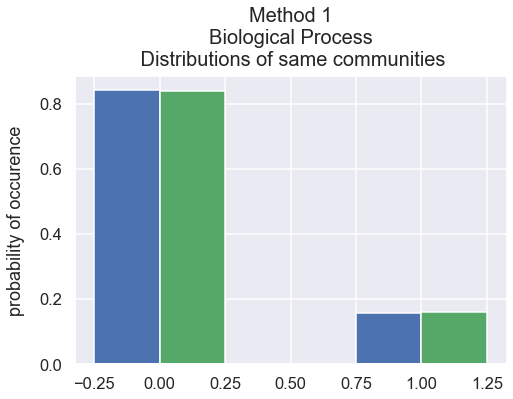

In [465]:
coworks_dist = np.load('./data/same communities-coworks_dist-bp-p1.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-bp-p1.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 1\nBiological Process\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

In [147]:
max(partition2.values())

254

In [457]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,6,None,partition1)
np.save('./data/same communities-coworks_dist-cc-p1.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-cc-p1.npy', ncoworks_dist)

--- 20.02 seconds ---


P-value for fisher exact test is : 4.4e-323


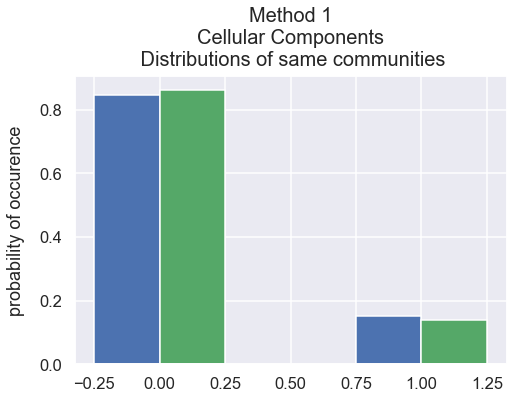

In [466]:
coworks_dist = np.load('./data/same communities-coworks_dist-cc-p1.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-cc-p1.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 1\nCellular Components\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

In [ ]:
  [(len(dist2) - sum(dist2))/len(dist2)],sum(dist2)/len(dist2)]

In [75]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,6,None,partition1)
np.save('./data/same communities-coworks_dist-mf-p1.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-mf-p1.npy', ncoworks_dist)

--- 9.11 seconds ---


P-value for fisher exact test is : 1.5516314492613962e-168


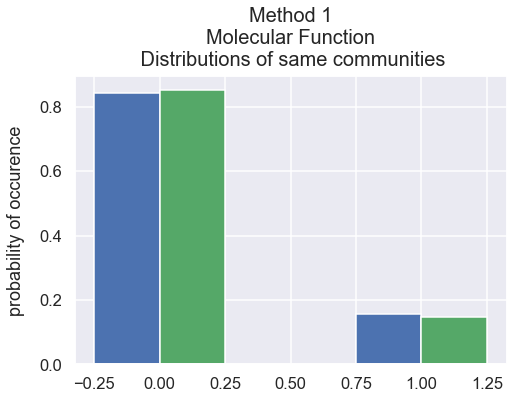

In [467]:
coworks_dist = np.load('./data/same communities-coworks_dist-mf-p1.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-mf-p1.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 1\nMolecular Function\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

### for method 2

In [113]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,6,None,partition2)
np.save('./data/same communities-coworks_dist-bp-p2.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-bp-p2.npy', ncoworks_dist)

--- 15.08 seconds ---


P-value for fisher exact test is : 9.225121043289476e-220


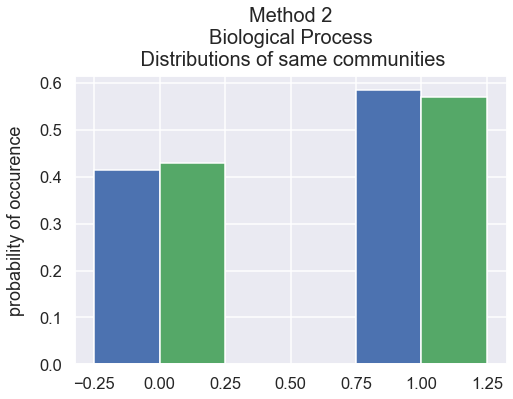

In [468]:
coworks_dist = np.load('./data/same communities-coworks_dist-bp-p2.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-bp-p2.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 2\nBiological Process\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

In [114]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,6,None,partition2)
np.save('./data/same communities-coworks_dist-cc-p2.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-cc-p2.npy', ncoworks_dist)

--- 20.01 seconds ---


P-value for fisher exact test is : 6.4e-323


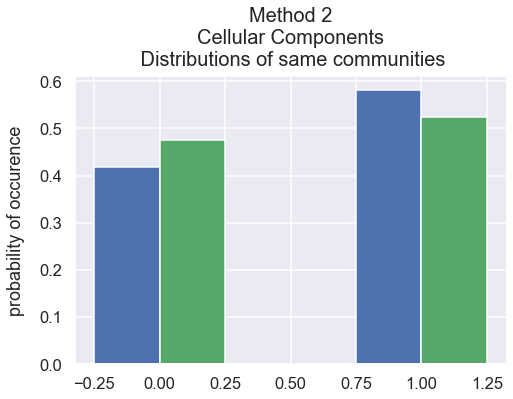

In [469]:
coworks_dist = np.load('./data/same communities-coworks_dist-cc-p2.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-cc-p2.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 2\nCellular Components\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

In [115]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,6,None,partition2)
np.save('./data/same communities-coworks_dist-mf-p2.npy', coworks_dist)
np.save('./data/same communities-ncoworks_dist-mf-p2.npy', ncoworks_dist)

--- 10.34 seconds ---


P-value for fisher exact test is : 7.4e-323


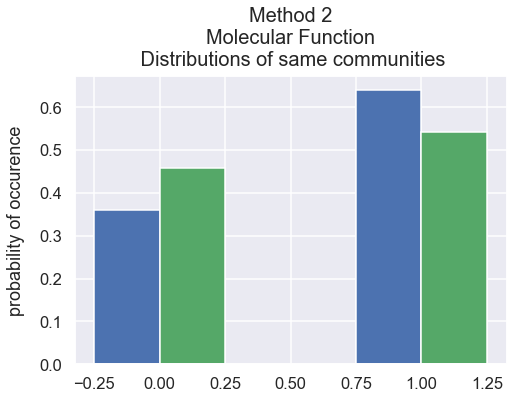

In [470]:
coworks_dist = np.load('./data/same communities-coworks_dist-mf-p2.npy')
ncoworks_dist = np.load('./data/same communities-ncoworks_dist-mf-p2.npy')
show_dist_bernoulli(coworks_dist,ncoworks_dist,"Method 2\nMolecular Function\n Distributions of same communities")
fisher(coworks_dist,ncoworks_dist)

## Same communities neighbors

### for method 1

In [98]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,7,None,partition1)
np.save('./data/same communities neighbors-coworks_dist-bp-p1.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-bp-p1.npy', ncoworks_dist)

--- 37.45 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


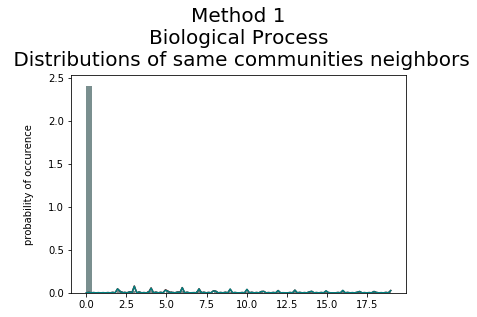

In [100]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-bp-p1.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-bp-p1.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 1\nBiological Process\n Distributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [99]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,7,None,partition1)
np.save('./data/same communities neighbors-coworks_dist-cc-p1.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-cc-p1.npy', ncoworks_dist)

--- 51.1 seconds ---


P-value for t test is : 2.4950317496896757e-187
P-value for the one-way ANOVA test is : 2.495031750374099e-187


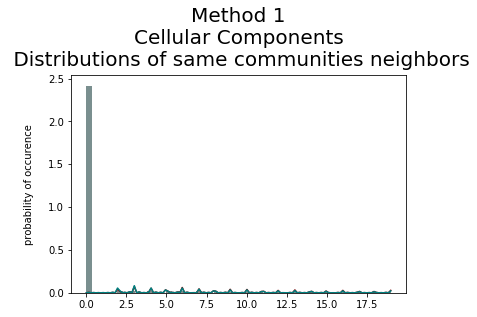

In [105]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-cc-p1.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-cc-p1.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 1\nCellular Components\n Distributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [101]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,7,None,partition1)
np.save('./data/same communities neighbors-coworks_dist-mf-p1.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-mf-p1.npy', ncoworks_dist)

--- 27.23 seconds ---


P-value for t test is : 0.5290728783863452
P-value for the one-way ANOVA test is : 0.5290728781981489


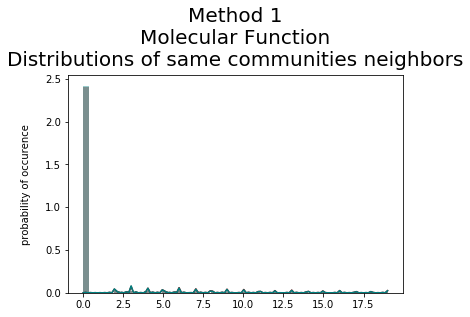

In [106]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-mf-p1.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-mf-p1.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 1\nMolecular Function\nDistributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

### for method 2

In [102]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,7,None,partition2)
np.save('./data/same communities neighbors-coworks_dist-bp-p2.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-bp-p2.npy', ncoworks_dist)

--- 57.78 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


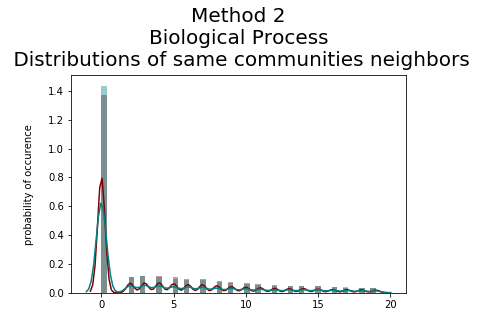

In [107]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-bp-p2.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-bp-p2.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 2\nBiological Process\n Distributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [103]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,7,None,partition2)
np.save('./data/same communities neighbors-coworks_dist-cc-p2.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-cc-p2.npy', ncoworks_dist)

--- 75.23 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


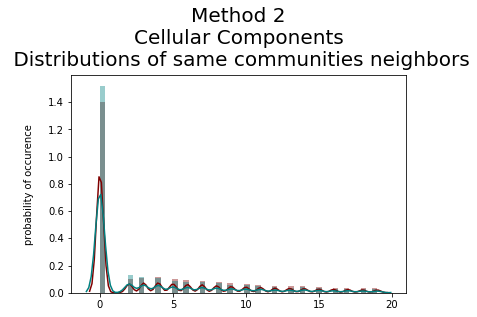

In [109]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-cc-p2.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-cc-p2.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 2\nCellular Components\n Distributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

In [104]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,7,None,partition2)
np.save('./data/same communities neighbors-coworks_dist-mf-p2.npy', coworks_dist)
np.save('./data/same communities neighbors-ncoworks_dist-mf-p2.npy', ncoworks_dist)

--- 39.94 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


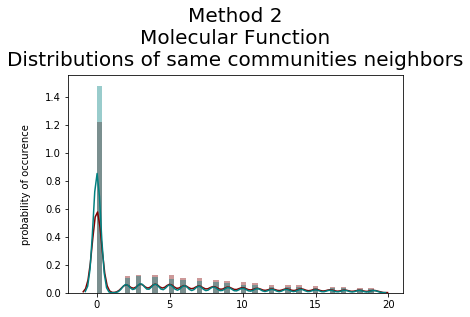

In [108]:
coworks_dist = np.load('./data/same communities neighbors-coworks_dist-mf-p2.npy')
ncoworks_dist = np.load('./data/same communities neighbors-ncoworks_dist-mf-p2.npy')
show_dist(coworks_dist[coworks_dist<20],ncoworks_dist[ncoworks_dist<20],"Method 2\nMolecular Function\nDistributions of same communities neighbors")
show_pvalue(coworks_dist,ncoworks_dist)

## Proposed method : participation coefficient 
### The Cliques Participation Index (CPI) as an Indicator of Creativity in Online Collaborative Groups 2014 

In [526]:
# Biological Process 
[coworks_dist,ncoworks_dist] = get_distribution(coworks_bp,ncoworks_bp,8,None,partition1)
np.save('./data/proposed method-coworks_dist-bp.npy', coworks_dist)
np.save('./data/proposed method-ncoworks_dist-bp.npy', ncoworks_dist)

--- 436.06 seconds ---


P-value for t test is : 4.678788674722507e-308
P-value for the one-way ANOVA test is : 4.67878867514665e-308


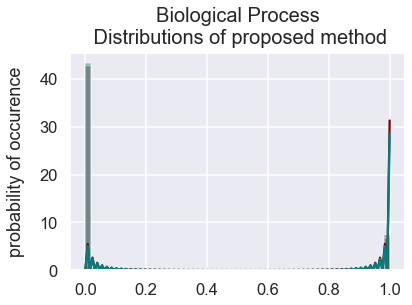

In [521]:
coworks_dist = np.load('./data/proposed method-coworks_dist-bp.npy')
ncoworks_dist = np.load('./data/proposed method-ncoworks_dist-bp.npy')
show_dist(coworks_dist,ncoworks_dist,"Biological Process\n Distributions of proposed method")
show_pvalue(coworks_dist,ncoworks_dist)

In [527]:
# Cellular Components
[coworks_dist,ncoworks_dist] = get_distribution(coworks_cc,ncoworks_cc,8,None,partition1)
np.save('./data/proposed method-coworks_dist-cc.npy', coworks_dist)
np.save('./data/proposed method-ncoworks_dist-cc.npy', ncoworks_dist)

--- 600.13 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


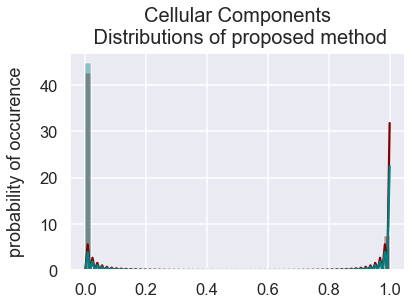

In [589]:
coworks_dist = np.load('./data/proposed method-coworks_dist-cc.npy')
ncoworks_dist = np.load('./data/proposed method-ncoworks_dist-cc.npy')
show_dist(coworks_dist,ncoworks_dist,"Cellular Components\n Distributions of proposed method")
show_pvalue(coworks_dist,ncoworks_dist)

In [528]:
# Molecular Function
[coworks_dist,ncoworks_dist] = get_distribution(coworks_mf,ncoworks_mf,8,None,partition1)
np.save('./data/proposed method-coworks_dist-mf.npy', coworks_dist)
np.save('./data/proposed method-ncoworks_dist-mf.npy', ncoworks_dist)

--- 301.32 seconds ---


P-value for t test is : 0.0
P-value for the one-way ANOVA test is : 0.0


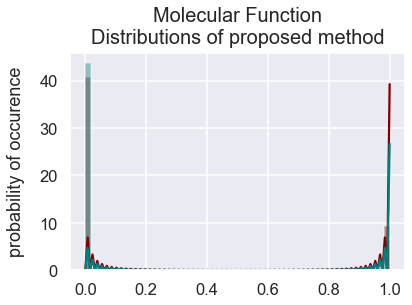

In [587]:
coworks_dist = np.load('./data/proposed method-coworks_dist-mf.npy')
ncoworks_dist = np.load('./data/proposed method-ncoworks_dist-mf.npy')
show_dist(coworks_dist,ncoworks_dist,"Molecular Function\nDistributions of proposed method")
show_pvalue(coworks_dist,ncoworks_dist)

In [127]:
def show_info(df):
    print(round(np.mean(df),4))
    print(round(np.var(df),4))
    print(round(np.std(df),4))
    print(round(np.min(df),4)) 
    print(round(np.max(df),4))             
df = np.load('./data/same communities neighbors-ncoworks_dist-mf-p1.npy')
df[df==-1] = max(df) + 1
show_info(df)

3.8429
346.038
18.6021
0
688
